## Conv Params
- Justifying can use modParc framework as days are convective.
- Uses `ds_tropics` generated from `load_ds_tropics` script that is run locally [🔗](https://github.com/jduffield65/Isca/blob/main/jobs/theory_lapse/cesm/thesis_figs/scripts/load_ds_tropics.py)
	- This script in turn requires `REFHT_quant50` to have been run on JASMIN to extract data from CESM raw data [🔗](https://github.com/jduffield65/Isca/blob/main/jobs/cesm/3_hour/hottest_quant/pre_industrial/REFHT_quant50/input.nml)

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import warnings
from isca_tools.plot import fig_resize, update_fontsize, update_linewidth, savefig, label_subplots
import os
import cartopy.crs as ccrs
import jobs.theory_lapse.cesm.thesis_figs.scripts.utils as utils
from tqdm.notebook import tqdm
from isca_tools.thesis.lapse_integral import integral_and_error_calc
from isca_tools.thesis.lapse_integral_simple import get_temp_2_layer_approx
from isca_tools.utils.constants import lapse_dry

warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# Formatting figures info
width = {'one_col': 3.2, 'two_col': 5.5}  # width in inches
im_sz = 1.5
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')
ax_linewidth = plt.rcParams['axes.linewidth']
leg_handlelength = 1.5

## Load Data
Once compute the parcel temperature at $p_{FT}$, I save the dataset as takes around 8 minutes to compute.

In [3]:
ds = {}
with tqdm(total=2, position=0, leave=True) as pbar:
    for surf in ['ocean', 'land']:
        ds[surf] = xr.load_dataset(os.path.join(utils.out_dir, f"ds_tropics_{surf}.nc"))
        # Chose best rh_mod
        ds[surf] = utils.sel_best_rh_mod(ds[surf])
        pbar.update(1)

  0%|          | 0/2 [00:00<?, ?it/s]

## Which $p_{FT}$ to choose
Here, 400hPa is better because more *convective* days according to error thresholding, and helps with topography issues i.e. more
regions have at least 100hPa from LCL to FT level.

In [4]:
print('Total number of convective days')
for key in ds:
    # get rid of nan - due to different amounts of land at each lat
    n_days = (~np.isnan(ds[key].TREFHT)).sum(dim=['quant', 'lat', 'lon_sample']).values
    for p_ft in ds[key].p_ft:
        var1 = utils.get_valid_mask(ds[key].sel(p_ft=p_ft), aloft_p_size_thresh=0).sum(
            dim=['quant', 'lat', 'lon_sample']).values / n_days * 100
        var2 = utils.get_valid_mask(ds[key].sel(p_ft=p_ft)
                                    ).sum(dim=['quant', 'lat', 'lon_sample']).values / n_days * 100
        print(key, float(p_ft / 100), 'No lcl masking', np.round(var1, 1), 'With lcl masking', np.round(var2, 1))

Total number of convective days
ocean 400.0 No lcl masking [87.3 80.6] With lcl masking [87.3 80.6]
ocean 500.0 No lcl masking [77.7 66.2] With lcl masking [77.7 66.2]
land 400.0 No lcl masking [91.  87.8] With lcl masking [88.6 86. ]
land 500.0 No lcl masking [79.5 71.3] With lcl masking [70.6 63.5]


### Fitting Error
Below we show that fitting error better for `mod_parcel` for aquaplanet but not land. Also, that `convflag` closer to 2 for aquaplanet indicating deep convection triggered more.

I use median and IQR for shading because `convflag` takes almost discrete values, so $\pm$ standard deviation shading looks way too big, given
that very few days have `convflag<1`. I.e. $\pm \sigma$ forces symmetric shading, when data is not symmetric about median.

In [5]:
p_ft_use = 400 * 100
for key in ds:
    ds[key] = ds[key].sel(p_ft=p_ft_use)

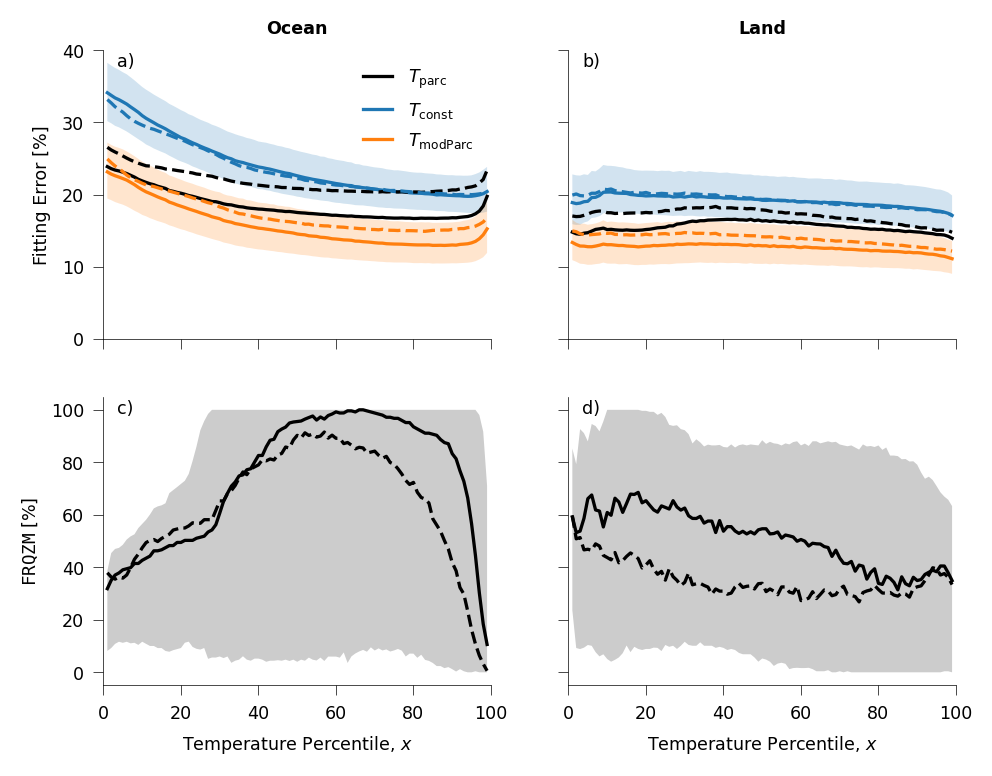

In [6]:
lat_weights = utils.lat_weights.reindex_like(ds['ocean'].lat)
label_methods = {'parcel': "$T_{\\text{parc}}$", 'const': "$T_{\\text{const}}$", 'mod_parcel': "$T_{\\text{modParc}}$"}

fig, ax = plt.subplots(2, 2, sharex=True, sharey='row')
fig_resize(fig, width['two_col'])
for k, surf_use in enumerate(ds):
    ds_use = ds[surf_use]
    ax[0, k].set_title(surf_use.capitalize(), fontweight='bold')
    ax[1, k].set_xlabel(utils.percentile_label)
    for j in range(ds['ocean'].co2.size):
        for i, key in enumerate(['parcel', 'const', 'mod_parcel']):
            if k == 0:
                label_use = label_methods[key] if j == 0 else None
            else:
                label_use = f"${ds['ocean'].co2[j]:.0f} \\times CO_2$" if i == 0 else None
            var = np.abs(
                ds_use[f"{key}_error"].sum(dim='layer') / ds_use[f"{key}_integral"].sum(dim='layer') * 100).isel(co2=j)
            ax[0, k].plot(ds_use.quant, np.average(var.quantile(0.5, dim='lon_sample'), axis=1, weights=lat_weights),
                          color='k' if key=='parcel' else f"C{i-1}",
                          linestyle=[None, '--'][j], label=label_use)
            if (j == 0) and (key != 'parcel'):
                ax[0, k].fill_between(ds_use.quant,
                                      np.average(var.quantile(0.25, dim='lon_sample'), axis=1, weights=lat_weights),
                                      np.average(var.quantile(0.75, dim='lon_sample'), axis=1, weights=lat_weights),
                                      alpha=0.2,
                                      color=f"C{i-1}", edgecolor="none")

        ax[1, k].plot(ds_use.quant, np.average(ds_use.FREQZM.quantile(0.5, dim='lon_sample').isel(co2=j) * 100, axis=1,
                                               weights=lat_weights),
                      color='k', linestyle=[None, '--'][j], label=f"${ds['ocean'].co2[j]:.0f} \\times CO_2$")
        if j == 0:
            ax[1, k].fill_between(ds_use.quant,
                                  np.average(ds_use.FREQZM.isel(co2=j).quantile(0.25, dim='lon_sample') * 100, axis=1,
                                             weights=lat_weights),
                                  np.average(ds_use.FREQZM.isel(co2=j).quantile(0.75, dim='lon_sample') * 100, axis=1,
                                             weights=lat_weights), alpha=0.2,
                                  color="k", edgecolor="none")

update_linewidth(fig, 1.5)
ax[0, 0].set_ylim(0, 40)
ax[0, 0].set_xlim(0, 100)
ax[0, 0].set_ylabel('Fitting Error [%]')
ax[1, 0].set_ylabel('$\mathtt{FRQZM}$ [%]')
ax[0, 0].legend(handlelength=leg_handlelength)
# ax[1, 0].legend(handlelength=leg_handlelength)
label_subplots(fig, ax.flatten(), pos_y=-1, box_alpha=0)
update_fontsize(fig)
plt.show()
# savefig(fig)

### Valid days
Below I plot the days for which `mod_parcel` has lower error than 25% and thus days valid to consider convctive.

Weighting is slightly different, in that I weight by amount of that surface at that latitude i.e. latitudes with more land contribute more to the land plot but less to the ocean.

There are more of these than for which the convection scheme actually triggered. Expected as WTG in tropics makes some locations look convective even if they are not. Goo to check that a more direct correspondence at higher latitudes, where no WTG, so more direct correspondence between looking convective and convection scheme triggered.

Captures variation with $x$ well, except hottest ocean days - probably coastal so land-like.

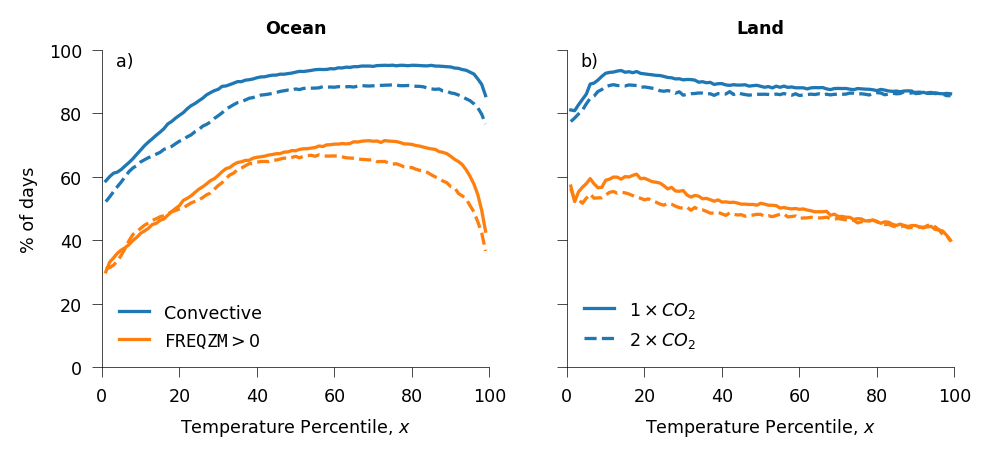

In [9]:
# Ensure when averaging over latitude for each quant, that weight the latitudes with more of that surface
weights_use = {}
for surf in ds:
    weights_use[surf] =  (~np.isnan(ds[surf].TREFHT)).sum(dim=['lon_sample', 'co2', 'quant'])
    weights_use[surf] = weights_use[surf] * lat_weights                      # combine with lat weights
    # set max to 1 for interpretation i.e. if weight=1 that lat contributes most
    weights_use[surf] = weights_use[surf] / weights_use[surf].max(dim='lat')       # set max to 1 for interpretation

labels_conv_def = ['Convective', '$\mathtt{FREQZM}>0$']
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
fig_resize(fig, width['two_col'])
for k, surf_use in enumerate(ds):
    ds_use = ds[surf_use]
    ax[k].set_title(surf_use.capitalize(), fontweight='bold')
    ax[k].set_xlabel(utils.percentile_label)
    mask_fit = utils.get_valid_mask(ds_use)
    n_sample = (~np.isnan(ds_use.TREFHT)).sum(dim='lon_sample')
    var = [mask_fit.sum(dim='lon_sample') / n_sample * 100, (ds_use.FREQZM > 0).sum(dim='lon_sample') / n_sample * 100]
    for j in range(ds['ocean'].co2.size):
        for i in range(len(var)):
            if k == 0:
                label_use = labels_conv_def[i] if j == 0 else None
            else:
                label_use = utils.co2_labels[j] if i == 0 else None
            ax[k].plot(ds_use.quant, var[i].isel(co2=j).weighted(weights_use[surf_use]).mean(dim='lat'), color=f"C{i}",
                       linestyle=[None, '--'][j], label=label_use)

update_linewidth(fig, 1.5)
label_subplots(fig, ax.flatten(), pos_y=-1, box_alpha=0)
ax[0].legend(handlelength=leg_handlelength)
ax[1].legend(handlelength=leg_handlelength)
ax[0].set_xlim(0, 100)
ax[0].set_ylim(0, 100)
ax[0].set_ylabel('% of days')
update_fontsize(fig)
plt.show()
# savefig(fig)

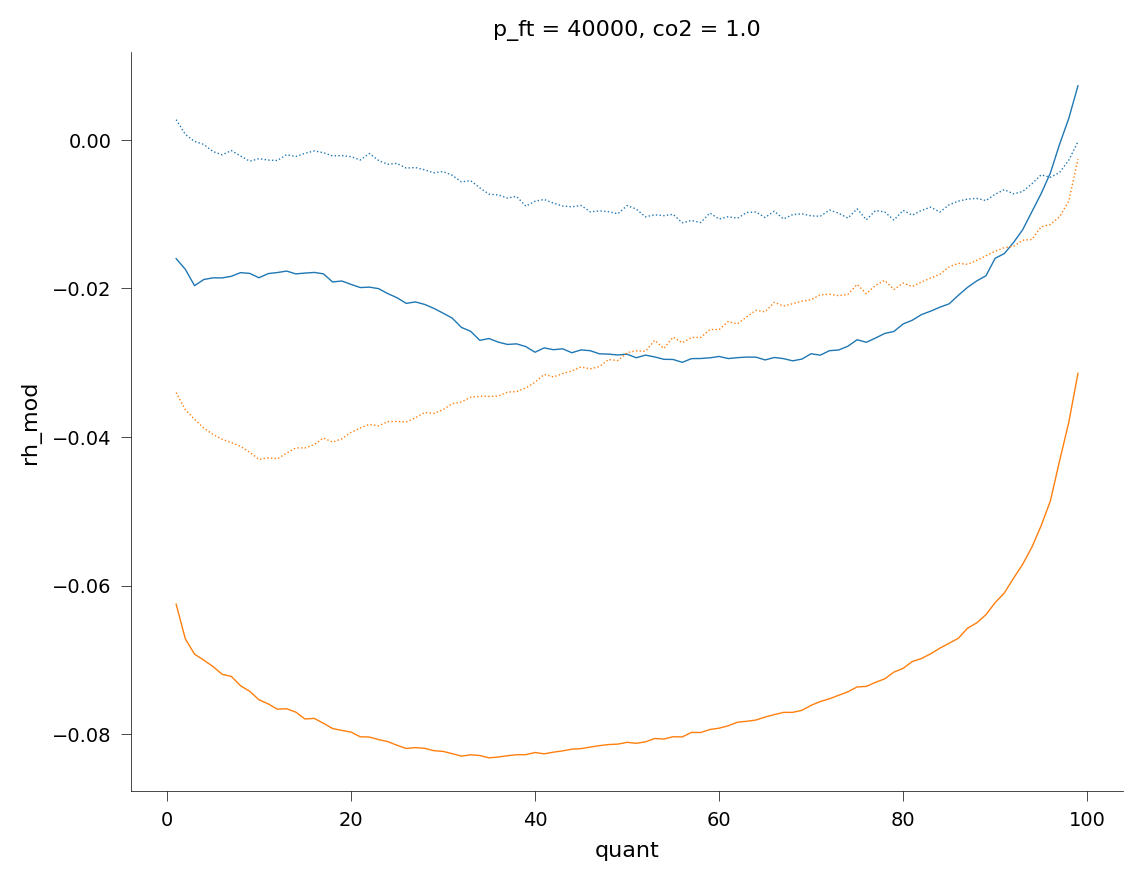

In [10]:
# For non-convective days, see that rh_mod is around 5% but for convective days is less than -5% for ocean. Big difference.
surf_use = 'ocean'
ds_use = ds[surf_use].isel(co2=0)
mask_fit = utils.get_valid_mask(ds_use)
ds_use.rh_mod[ds_use.const_rh_mod_ind].where(mask_fit).mean(dim='lon_sample').weighted(weights_use[surf_use]).mean(dim='lat').plot(c='C0')
ds_use.rh_mod[ds_use.mod_parcel_rh_mod_ind].where(mask_fit).mean(dim='lon_sample').weighted(weights_use[surf_use]).mean(dim='lat').plot(c='C1')

ds_use.rh_mod[ds_use.const_rh_mod_ind].where(~mask_fit).mean(dim='lon_sample').weighted(weights_use[surf_use]
                                                                                        ).mean(dim='lat').plot(c='C0', linestyle=':')
ds_use.rh_mod[ds_use.mod_parcel_rh_mod_ind].where(~mask_fit).mean(dim='lon_sample').weighted(weights_use[surf_use]
                                                                                             ).mean(dim='lat').plot(c='C1', linestyle=':')

# ds_use.const_lapse.isel(layer=0).where(mask_fit).mean(dim='lon_sample').weighted(weights_use[surf_use]).mean(dim='lat').plot(c='C0')
# ds_use.mod_parcel_lapse.isel(layer=0).where(mask_fit).mean(dim='lon_sample').weighted(weights_use[surf_use]).mean(dim='lat').plot(c='C1')
#
# ds_use.const_lapse.isel(layer=0).where(~mask_fit).mean(dim='lon_sample').weighted(weights_use[surf_use]
#                                                                                         ).mean(dim='lat').plot(c='C0', linestyle=':')
# ds_use.mod_parcel_lapse.isel(layer=0).where(~mask_fit).mean(dim='lon_sample').weighted(weights_use[surf_use]
#                                                                                              ).mean(dim='lat').plot(c='C1', linestyle=':')

### Valid days - Spatial distribution
I repeat the above plot but with a spatial dimension, to compare definitions across location, rather than $x$.

The west coast of South America is non-convective, and colder. Probably due to trade winds bringing up cold air. In NH, land not configured in such a way that allows for this pattern i.e. more land in NH so warmer.

Slab ocean, so not due to ocean current stuff.

Not to do with El Nino, it is just the SST mean conditions in slab ocean simulations that this region is cold e.g. [Fig 1f in this paper](https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2010GL044888).

In CESM, a slab ocean model (SOM) is a simplified ocean component, often used to study atmospheric processes by excluding complex ocean dynamics like 3D currents, but it can still simulate upwelling, especially coastal upwelling driven by wind, by allowing cold, deep water (or just cooler surface water in the simplified case) to rise in regions like the eastern Pacific where trade winds push warm water away, impacting sea surface temperatures (SSTs) and climate feedbacks. While full ocean dynamics (like deep ocean heat uptake) are missing, CESM's slab version captures key air-sea interactions, allowing for investigations into how heat uptake patterns, such as in the Southern Ocean, teleconnect to tropical SSTs and influence climate.
https://share.google/aimode/yF7EKiTk3D6MjSQJA

In [11]:
%%time
ds_spatial = []
for exp_name in utils.exp_names:
    ds_spatial.append(utils.load_ds(exp_name, 50,
                                    ['const_lapse', 'const_error', 'const_integral',
                                     'mod_parcel_lapse', 'mod_parcel_error', 'mod_parcel_integral',
                                     'TREFHT', 'rh_REFHT', 'PS', 'LANDFRAC', 'FREQZM']).sel(
        p_ft=p_ft_use))
ds_spatial = xr.concat(ds_spatial, dim=ds['ocean'].co2)
ds_spatial = utils.sel_best_rh_mod(ds_spatial)

CPU times: user 34.7 s, sys: 7.13 s, total: 41.8 s
Wall time: 47.3 s


In [12]:
mask_spatial = utils.get_valid_mask(ds_spatial)
n_sample = (~np.isnan(ds_spatial.TREFHT)).sum(dim='sample')  # should match sample.size here, as one value for each lat, lon
conv_frac = [(mask_spatial).sum(dim='sample') / n_sample * 100,
             (ds_spatial.FREQZM > 0).sum(dim='sample') / n_sample * 100]

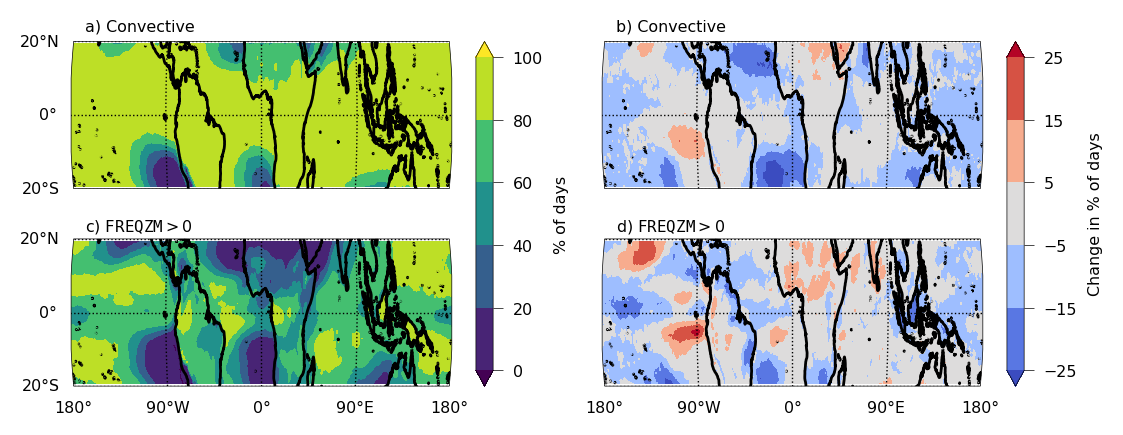

In [15]:
gl_fontsize = 5.74  # sets gridlines font - update_fontsize() does no change it
fig = plt.figure(constrained_layout=True)
ax = fig.subplots(2, 2, subplot_kw={'projection': ccrs.Robinson()}, gridspec_kw={'hspace': 0.1, 'wspace': 0})
# fig_resize(fig, 10, ar=5)
fig_resize(fig, width['two_col'])
# for ax_use in ax.flatten():
#     ax_use.set_aspect('auto')
#     ax_use.set_extent([-180, 180, -20, 20], crs=ccrs.PlateCarree())
#     ax_use.coastlines()
for i in range(ds['ocean'].co2.size):
    for j in range(len(conv_frac)):
        if i == 0:
            var = conv_frac[j].isel(co2=i)
            levels = np.linspace(0, 100, 6)
            cmap = 'viridis'
        else:
            var = conv_frac[j].diff(dim='co2').squeeze()
            levels = np.linspace(-25, 25, 6)
            cmap = 'coolwarm'
        gl = utils.initialize_ax_projection(ax[j, i], lat_min=-20.01, lat_max=20.01, auto_aspect=True, gridline_lw=0.5,
                                            grid_lat=[-20, 0, 20], grid_lon=[-180, -90, 0, 90, 180], return_gl=True)[1]
        if i == 1:
            gl.left_labels = False
        if j == 0:
            gl.bottom_labels = False
        gl.xlabel_style = {"size": gl_fontsize}
        gl.ylabel_style = {"size": gl_fontsize}
        im = utils.plot_contour_projection(ax[j, i], var, levels=levels, cmap=cmap)
    plt.colorbar(im, ax=ax[:, i].ravel(), label='% of days' if i == 0 else 'Change in % of days', pad=0.02)
label_subplots(fig, ax.flatten(), box_alpha=0, pos_y=8, labels=[f'a) {labels_conv_def[0]}', f'b) {labels_conv_def[0]}',
                                                                f'c) {labels_conv_def[1]}', f'd) {labels_conv_def[1]}'])
update_fontsize(fig)
plt.show()
# savefig(fig)

In [23]:
# Mean relative humidity of land surface
print(ds['land'].rh_REFHT.weighted(utils.lat_weights).mean(dim=['lat', 'quant', 'lon_sample']).values)
print(ds['land'].rh_REFHT.weighted(utils.lat_weights).std(dim=['lat', 'quant', 'lon_sample']).values)
# ds['land'].rh_REFHT.weighted(utils.lat_weights).std(dim=['lat', 'quant', 'lon_sample'])

[0.40724295 0.39130625]
[0.19883704 0.18553905]
